In [2]:
import cv2
import numpy 
import copy
from scipy.spatial import distance
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def win_check(Square_position):
    img = cv2.imread('Dots_Lines.jpg')
    fg = True
    for i in Square_position:
        a,b = i
        
        if sum(img[a][b]) == 720:
            fg = True
            break
        else:
            fg = False
    return fg

In [4]:
def first_player():
    return random.choice(['Blue','Red'])

In [5]:
class Player:
    
    def __init__(self, color, score = 0,turn = None):
        self.color = color
        self.score = score
        self.turn = turn

In [6]:
def Box_Check(Board,Boxes):
    
    if all(Board[i] != ' ' for i in [0,2,3,5]) and 0 in Boxes:
        Boxes.remove(0)
        return True,Boxes
    elif all(Board[i] != ' ' for i in [1,3,4,6]) and 1 in Boxes:
        Boxes.remove(1)
        return True,Boxes
    elif all(Board[i] != ' ' for i in [5,7,8,10]) and 2 in Boxes:
        Boxes.remove(2)
        return True,Boxes
    elif all(Board[i] != ' ' for i in [6,8,9,11]) and 3 in Boxes:
        Boxes.remove(3)
        return True,Boxes
    else:
        return False,Boxes

In [7]:
def Game_Complete(Board):
    if all(Board[i] != ' ' for i in range(12)):
        return True
    else:
        return False

In [8]:
def ID(board):
    return '.'.join(str(val) for val in board)

In [9]:
def updateQ(Q, IDlist, Actionlist, Reward, alpha, gamma):
    
    IDlist.reverse()
    Actionlist.reverse()
    for i,ID in enumerate(IDlist):
        if i == 0:
            if ID not in Q:
                Q.update({ID:[0,0,0,0,0,0,0,0,0,0,0,0]})
            Q[ID][Board_dictionary(str(Actionlist[i]))] = Reward
        else:
            if ID not in Q:
                Q.update({ID:[0,0,0,0,0,0,0,0,0,0,0,0]})
            prev_reward = Q[ID][Board_dictionary(str(Actionlist[i]))]
            Q[ID][Board_dictionary(str(Actionlist[i]))] = (1-alpha)*prev_reward + alpha*(Reward + gamma*max(Q[IDlist[i-1]]))
    
    return Q

In [10]:
def BestMove(Q,ID):
    
    return Q[ID].index(max(Q[ID]))

In [11]:
def Board_dictionary(string):
    Board_Dictioanry = {'[(200, 200), (250, 200)]': 0,
                  '[(250, 200), (300, 200)]': 1,
                  '[(200, 200), (200, 250)]': 2,
                  '[(250, 200), (250, 250)]': 3,
                  '[(300, 200), (300, 250)]': 4,
                  '[(200, 250), (250, 250)]': 5,
                  '[(250, 250), (300, 250)]': 6,
                  '[(200, 250), (200, 300)]': 7,
                  '[(250, 250), (250, 300)]': 8,
                  '[(300, 250), (300, 300)]': 9,
                  '[(200, 300), (250, 300)]': 10,
                  '[(250, 300), (300, 300)]': 11}
    return Board_Dictioanry[string]

In [12]:
def Train(no_ofEpisodes, alpha, gamma, expFac, player):
    
    Q1 = {}
    Q2 = {}
    
    Actions = [[(200, 200), (250, 200)],[(250, 200), (300, 200)],
                        [(200, 200), (200, 250)],[(250, 200),(250, 250)],[(300, 200), (300, 250)],
                        [(200, 250), (250, 250)],[(250, 250), (300, 250)],
                        [(200, 250), (200, 300)],[(250, 250), (250, 300)],[(300, 250), (300, 300)],
                        [(200, 300), (250, 300)],[(250, 300), (300, 300)]]
    
    if player == 'Blue':
        e1 = 0.5
        e2 = 1.0
    elif player == 'Red':
        e1 = 1.0
        e2 = 0.5
        
    win = 0
    lose = 0
    tie = 0
    invalid = 0
    fg = 0
    fg2 = 0
        
    P1 = Player('Blue')
    P2 = Player('Red')

    for i in range(no_ofEpisodes):
        fg2 = 0
        Boxes = [0,1,2,3]
        Board = [' ']*12
        Valid_Actions = [[(200, 200), (250, 200)],[(250, 200), (300, 200)],
                         [(200, 200), (200, 250)],[(250, 200),(250, 250)],[(300, 200), (300, 250)],
                         [(200, 250), (250, 250)],[(250, 250), (300, 250)],
                         [(200, 250), (200, 300)],[(250, 250), (250, 300)],[(300, 250), (300, 300)],
                         [(200, 300), (250, 300)],[(250, 300), (300, 300)]]

        fp = first_player()
        if P1.color == first_player:
            P1.turn = True
            P2.turn = False
        else:
            P1.turn = False
            P2.turn = True

        P1IDlist = []
        P1Actionlist = []
        P2IDlist = []
        P2Actionlist = []

        while not Game_Complete(Board):
            
            if P1.turn == True and len(Valid_Actions) != 0:
                stateID = ID(Board)
                P1IDlist.append(stateID)
                if random.random() < e1 or stateID not in Q1.keys():
                    line = random.choice(Valid_Actions)
                else:
                    line = Actions[BestMove(Q1,stateID)]
                    
                Board[Board_dictionary(str(line))] = P1.color
                P1Actionlist.append(line)
                
                if line not in Valid_Actions:
                    invalid += 1
                    Q1 = updateQ(Q1, P1IDlist, P1Actionlist, 0, alpha, gamma)
                    fg2 = 1
                    break
                Valid_Actions.remove(line)
                
                F,Boxes = Box_Check(Board,Boxes)
                if F:
                    P1.score += 1
                    Q1 = updateQ(Q1, P1IDlist, P1Actionlist, 1, alpha, gamma)
                    Q2 = updateQ(Q2, P2IDlist, P2Actionlist, -1, alpha, gamma)
                    P1.turn = True
                    P2.turn = False
                    
                    F,Boxes = Box_Check(Board,Boxes)
                    if F:
                        P1.score += 1
                        Q1 = updateQ(Q1, P1IDlist, P1Actionlist, 1, alpha, gamma)
                        Q2 = updateQ(Q2, P2IDlist, P2Actionlist, -1, alpha, gamma)
                        P1.turn = True
                        P2.turn = False

                P1.turn = False
                P2.turn = True

            elif P2.turn == True and len(Valid_Actions) != 0:
                stateID = ID(Board)
                P2IDlist.append(ID(Board))
                if random.random() < e2 or stateID not in Q2.keys():
                    line = random.choice(Valid_Actions)
                else: 
                    line = Actions[BestMove(Q2,stateID)]

                Board[Board_dictionary(str(line))] = P2.color

                P2Actionlist.append(line)
                if line not in Valid_Actions:
                    invalid += 1
                    Q2 = updateQ(Q2, P2IDlist, P2Actionlist, 0, alpha, gamma)
                    fg2 = 1
                    break
                Valid_Actions.remove(line)

                F,Boxes = Box_Check(Board,Boxes)
                if F:
                    P2.score += 1
                    Q1 = updateQ(Q1, P1IDlist, P1Actionlist, -1, alpha, gamma)
                    Q2 = updateQ(Q2, P2IDlist, P2Actionlist, 1, alpha, gamma)
                    P1.turn = False
                    P2.turn = True
                    
                    F,Boxes = Box_Check(Board,Boxes)
                    if F:
                        P2.score += 1
                        Q1 = updateQ(Q1, P1IDlist, P1Actionlist, -1, alpha, gamma)
                        Q2 = updateQ(Q2, P2IDlist, P2Actionlist, 1, alpha, gamma)
                        P1.turn = False
                        P2.turn = True

                P1.turn = True
                P2.turn = False

        if(fg2 == 1):
            continue
    
        if P1.score > P2.score:
            Q1 = updateQ(Q1, P1IDlist, P1Actionlist, 5, alpha, gamma)
            Q2 = updateQ(Q2, P2IDlist, P2Actionlist, -5, alpha, gamma)
            if P1.color == player:
                win+=1
                plt.subplot(2,2,1)
                plt.plot(i,win,'xg')
            else:
                lose+=1
                plt.subplot(2,2,2)
                plt.plot(i,lose,'xr')
            
            
        elif P2.score > P1.score:
            Q1 = updateQ(Q1, P1IDlist, P1Actionlist, -5, alpha, gamma)
            Q2 = updateQ(Q2, P2IDlist, P2Actionlist, 5, alpha, gamma)
            if P2.color == player:
                win+=1
                plt.subplot(2,2,1)
                plt.plot(i,win,'xg')
            else:
                lose+=1
                plt.subplot(2,2,2)
                plt.plot(i,lose,'xr')
            
        elif P1.score == P2.score:
            Q1 = updateQ(Q1, P1IDlist, P1Actionlist, 0, alpha, gamma)
            Q2 = updateQ(Q2, P2IDlist, P2Actionlist, 0, alpha, gamma)
            tie+=1
            plt.subplot(2,2,3)
            plt.plot(i,tie,'xb')
        
        if player == 'Blue':
            if e1 > 0.01:
                e1 *= expFac
        elif player == 'Red':
            if e2 > 0.01:
                e2 *= expFac

    print('win',win)
    print('lose',lose)
    print('tie',tie)
    print('invalid',invalid)
    return Q1,Q2

win 1354
lose 0
tie 2
invalid 8644


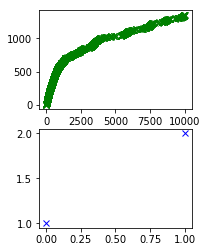

In [16]:
Q1,_ = Train(no_ofEpisodes=10000, alpha=0.09, gamma=0.6, expFac=0.6,player = 'Blue')
plt.show()

In [18]:
def Q_RandomPlayer(no_ofGames,Q):
    
    Possible_Actions = [[(200, 200), (250, 200)],[(250, 200), (300, 200)],
                        [(200, 200), (200, 250)],[(250, 200),(250, 250)],[(300, 200), (300, 250)],
                        [(200, 250), (250, 250)],[(250, 250), (300, 250)],
                        [(200, 250), (200, 300)],[(250, 250), (250, 300)],[(300, 250), (300, 300)],
                        [(200, 300), (250, 300)],[(250, 300), (300, 300)]]
    
    win = 0
    lose = 0
    tie = 0
    nottrained = 0
    
    for i in range(no_ofGames):
        Board = [' ']*12
        Boxes = [0,1,2,3]
        Valid_Actions = [[(200, 200), (250, 200)],[(250, 200), (300, 200)],
                         [(200, 200), (200, 250)],[(250, 200),(250, 250)],[(300, 200), (300, 250)],
                         [(200, 250), (250, 250)],[(250, 250), (300, 250)],
                         [(200, 250), (200, 300)],[(250, 250), (250, 300)],[(300, 250), (300, 300)],
                         [(200, 300), (250, 300)],[(250, 300), (300, 300)]]

        P1 = Player('Blue')
        P2 = Player('random')

        fp = first_player()
        if P1.color == first_player:
            P1.turn = True
            P2.turn = False
        else:
            P1.turn = False
            P2.turn = True

        while not Game_Complete(Board):

            if P1.turn == True and len(Valid_Actions) != 0:
                stateID = ID(Board)
                if stateID not in Q.keys():
                    line = random.choice(Valid_Actions)
                    nottrained += 1
                else:
                    line = Possible_Actions[BestMove(Q,stateID)]

                Board[Board_dictionary(str(line))] = P1.color
                Valid_Actions.remove(line)

                F,Boxes = Box_Check(Board,Boxes)
                if F:
                    P1.score += 1
                    P1.turn = True
                    P2.turn = False
                    
                    F,Boxes = Box_Check(Board,Boxes)
                    if F:
                        P1.score += 1
                        P1.turn = True
                        P2.turn = False

                P1.turn = False
                P2.turn = True

            elif P2.turn == True and len(Valid_Actions) != 0:

                line = random.choice(Valid_Actions)

                Board[Board_dictionary(str(line))] = P2.color
                Valid_Actions.remove(line)

                F,Boxes = Box_Check(Board,Boxes)
                if F:
                    P2.score += 1
                    P1.turn = False
                    P2.turn = True
                    
                    F,Boxes = Box_Check(Board,Boxes)
                    if F:
                        P2.score += 1
                        P1.turn = False
                        P2.turn = True

                P1.turn = True
                P2.turn = False


        if P1.score > P2.score:
            win+=1

        elif P2.score > P1.score:
            lose+=1

        elif P1.score == P2.score:
            tie+=1


    print('win',win)
    print('lose',lose)
    print('tie',tie)
    print('not trained',nottrained)

In [21]:
Q_RandomPlayer(10000,Q1)

win 4285
lose 918
tie 4797
not trained 60000


In [23]:
def GetTarget(Q):
    Target_Values = []
    for key in Q.keys():
        Target_Values.append(Q[key].index(max(Q[key])))
        
    return Target_Values

def Board2Int(Board):
    Y = 0
    X = Board.split('.')
    for i in range(len(X)):
        if X[i] == 'Blue':
            Y += 1
        elif X[i] == 'Red':
            Y += (3**i)
        elif X[i] == ' ':
            Y += (3**i)*2
    return Y + 1

In [24]:
def Train_NN(Q):
    w_vector=numpy.zeros((len(Q),15))

    before=current=after=None
    count = 1000
    
    while count > 0:
        w_count = 0
        
        for j in Q.keys():

            q = Board2Int(j)
            w_vector[w_count] = q
            for i in range(1,13):


                a = i-1
                b = i
                c = i+1
                before = w_vector[w_count][a]
                current = w_vector[w_count][b]
                after = w_vector[w_count][c]
                y_sum = (before+current+after)
                #print('y_sum=',y_sum)

                y_error = Q[j][i-1] - y_sum

                y_error_corrected=(y_error/3)

                w_vector[w_count][a]=(y_error_corrected)+(w_vector[w_count][a])
                w_vector[w_count][b]=(y_error_corrected)+(w_vector[w_count][b])
                w_vector[w_count][c]=(y_error_corrected)+(w_vector[w_count][c])
            
            w_count += 1

        count = count - 1
       # print(count)
         
    return w_vector

In [25]:
NN = Train_NN(Q1)

In [26]:
def NN_RandomPlayer(no_ofGames,NN):
    
    Possible_Actions = [[(200, 200), (250, 200)],[(250, 200), (300, 200)],
                        [(200, 200), (200, 250)],[(250, 200),(250, 250)],[(300, 200), (300, 250)],
                        [(200, 250), (250, 250)],[(250, 250), (300, 250)],
                        [(200, 250), (200, 300)],[(250, 250), (250, 300)],[(300, 250), (300, 300)],
                        [(200, 300), (250, 300)],[(250, 300), (300, 300)]]
    
    win = 0
    lose = 0
    tie = 0
    nottrained = 0
    
    for i in range(no_ofGames):
        Board = [' ']*12
        Boxes = [0,1,2,3]
        Valid_Actions = [[(200, 200), (250, 200)],[(250, 200), (300, 200)],
                         [(200, 200), (200, 250)],[(250, 200),(250, 250)],[(300, 200), (300, 250)],
                         [(200, 250), (250, 250)],[(250, 250), (300, 250)],
                         [(200, 250), (200, 300)],[(250, 250), (250, 300)],[(300, 250), (300, 300)],
                         [(200, 300), (250, 300)],[(250, 300), (300, 300)]]

        P1 = Player('Blue')
        P2 = Player('random')

        fp = first_player()
        if P1.color == first_player:
            P1.turn = True
            P2.turn = False
        else:
            P1.turn = False
            P2.turn = True

        while not Game_Complete(Board):

            if P1.turn == True and len(Valid_Actions) != 0:
                stateID = ID(Board)
                if Board2Int(stateID) not in NN[:][0]:
                    line = random.choice(Valid_Actions)
                    nottrained += 1
                else:
                    x,y = numpy.where(Board2Int(stateID))
                    p,q = numpy.where(w = numpy.max(NN[int(x)][1:]))
                    line = possible_Actions[int(q)-1]

                Board[Board_dictionary(str(line))] = P1.color
                Valid_Actions.remove(line)

                F,Boxes = Box_Check(Board,Boxes)
                if F:
                    P1.score += 1
                    P1.turn = True
                    P2.turn = False
                    
                    F,Boxes = Box_Check(Board,Boxes)
                    if F:
                        P1.score += 1
                        P1.turn = True
                        P2.turn = False

                P1.turn = False
                P2.turn = True

            elif P2.turn == True and len(Valid_Actions) != 0:

                line = random.choice(Valid_Actions)

                Board[Board_dictionary(str(line))] = P2.color
                Valid_Actions.remove(line)

                F,Boxes = Box_Check(Board,Boxes)
                if F:
                    P2.score += 1
                    P1.turn = False
                    P2.turn = True
                    F,Boxes = Box_Check(Board,Boxes)
                    if F:
                        P2.score += 1
                        P1.turn = False
                        P2.turn = True

                P1.turn = True
                P2.turn = False

    
        if P1.score > P2.score:
            win+=1

        elif P2.score > P1.score:
            lose+=1

        elif P1.score == P2.score:
            tie+=1


    print('win',win)
    print('lose',lose)
    print('tie',tie)
    print('not trained',nottrained)

In [29]:
NN_RandomPlayer(10000,NN)

win 4279
lose 883
tie 4838
not trained 60000
